In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer, mean_squared_error
import xgboost as xgb

import warnings
warnings.simplefilter('ignore')
#赤背景になっている警告を非表示に

効果がなかったこと
* 正規化、歪度の調整
* poachと部屋面積の特徴量を追加
* 外れ値を削除
* nullのボリュームが多い特徴量をNoにする
* A:1階/2階と地下の総面積と、地下室の舗装された面積と1階/2階の面積を足した特徴量を追加
* Aに加えて、areaの特徴量を削除
* streetとutilitiesの特徴量を削除

こちらの前処理のほうが効果が出るモデル
* randomforest：0.15102
* xgboost：0.14278


In [2]:
sample_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
test_original = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
train_original = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train = train_original
test = test_original
y_train = train_original["SalePrice"]

data_origin=pd.concat([train,test])
data_origin.index = np.arange(1,2920)
data = data_origin

In [3]:
"""
print(len(data))
data.isnull().sum().sort_values(ascending=False).head(40)
data["GarageCars"].dtypes
"""

'\nprint(len(data))\ndata.isnull().sum().sort_values(ascending=False).head(40)\ndata["GarageCars"].dtypes\n'

In [4]:
drop_columns = ["PoolQC","MiscFeature","Alley","Fence","MasVnrType","FireplaceQu"]
data = data.drop(drop_columns,axis=1)

In [5]:
null_No_list=['BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2',
              'GarageType','GarageFinish', 'GarageQual', 'GarageCond']
data[null_No_list] = data[null_No_list].fillna("No")

null_category_list = ["MSZoning","Utilities","Exterior1st","Exterior2nd", 'Electrical',
                      'KitchenQual', 'Functional', "SaleType"]
data[null_category_list] = data[null_category_list].fillna(data.mode().iloc[0])

null_float_list = ['MasVnrArea']
data[null_float_list] = data[null_float_list].fillna(data.median(numeric_only=True))

data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

data[['GarageCars','GarageArea',"GarageYrBlt"]] = data[['GarageCars','GarageArea',"GarageYrBlt"]].fillna(float(0))
data[['BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']] = data[['BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']].fillna(float(0))

#transform関数とは、欠損値をカテゴリー別に補完したいときに使う関数のこと
#df['新しい列'] = df.groupby('グループ化したい列')['操作したい列'].transform(適用したい関数)

#data["GarageYrBlt"] = data['GarageYrBlt'].fillna(data['YearBuilt'])
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
2,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
3,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500.0
4,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000.0
5,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,6,2006,WD,Normal,NaN
2916,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,4,2006,WD,Abnorml,NaN
2917,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2006,WD,Abnorml,NaN
2918,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,700,7,2006,WD,Normal,NaN


In [6]:
label_encode_list = ["ExterQual","ExterCond","BsmtQual","BsmtCond","HeatingQC","KitchenQual","GarageQual","GarageCond"]
qal_object = ["Ex","Gd","TA","Fa","Po","No"]
qal_float = [5,4,3,2,1,0]
data[label_encode_list] = data[label_encode_list].replace(qal_object,qal_float)

qal_object_garage = ["Fin","RFn","Unf","No"]
qal_float_garage = [3,2,1,0]
data["GarageFinish"] = data["GarageFinish"].replace(qal_object_garage,qal_float_garage)

qal_object_bsmt = ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","No"]
qal_float_bsmt = [6,5,4,3,2,1,0]
data[["BsmtFinType1","BsmtFinType2"]] = data[["BsmtFinType1","BsmtFinType2"]].replace(qal_object_bsmt,qal_float_bsmt)

In [7]:
data["YrPsdBlt"] = 2024 - data["YearBuilt"]
data["YrPsdRmd"] = 2024 - data["YearRemodAdd"]
data = data.drop(["YearBuilt","YearRemodAdd"],axis=1)

In [8]:
data_price=data["SalePrice"]

data_obj = data.select_dtypes(include=object)
data_obj_dummy = pd.get_dummies(data_obj,dtype=int)
data_obj_dummy

data_number = data.select_dtypes(include="number")
data_number = data_number.drop("SalePrice",axis=1)

data_train = data_obj_dummy.join(data_price)
data_train = data_train.join(data_number)
data_train

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,YrPsdBlt,YrPsdRmd
1,0,0,0,1,0,0,1,0,0,0,...,61,0,0,0,0,0,2,2008,21,21
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,5,2007,48,48
3,0,0,0,1,0,0,1,1,0,0,...,42,0,0,0,0,0,9,2008,23,22
4,0,0,0,1,0,0,1,1,0,0,...,35,272,0,0,0,0,2,2006,109,54
5,0,0,0,1,0,0,1,1,0,0,...,84,0,0,0,0,0,12,2008,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,6,2006,54,54
2916,0,0,0,0,1,0,1,0,0,0,...,24,0,0,0,0,0,4,2006,54,54
2917,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,9,2006,64,28
2918,0,0,0,1,0,0,1,0,0,0,...,32,0,0,0,0,700,7,2006,32,32


In [9]:
area_list = ["TotalBsmtSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea"]
data_train["area"] = data_train[area_list].sum(axis=1)

qual_list = ["BsmtQual","ExterQual","KitchenQual","GarageQual"]
data_train["qual"] = data_train[qual_list].sum(axis=1)

bath_count = ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]
data_train["bath_count"] = data_train[bath_count].sum(axis=1)

year_count = ["YrPsdBlt","YrPsdRmd"]
data_train["year_count"] = data_train[year_count].sum(axis=1)

In [10]:
del_list = ['MSZoning_C (all)', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn',
       'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd',
       'Exterior2nd_Other', 'Exterior2nd_Stone', 'Exterior2nd_Stucco',
       'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'Foundation_CBlock',
       'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood',
       'Exterior1st_WdShing', 'BsmtExposure_Mn', 'Exterior1st_Wd Sdng',
       'Exterior1st_Stone', 'RoofStyle_Shed', 'RoofMatl_ClyTile',
       'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake',
       'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn',
       'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_Plywood',
       'Exterior1st_Stucco', 'RoofStyle_Mansard', 'Heating_Floor',
       'Heating_GasW', 'PavedDrive_Y', 'SaleType_COD', 'SaleType_CWD',
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_Oth', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Partial', 'BsmtFinType2',
       'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal', 'PavedDrive_P',
       'Heating_GasA', 'PavedDrive_N', 'GarageType_CarPort', 'Heating_Grav',
       'Heating_OthW', 'Heating_Wall', 'CentralAir_Y', 'Electrical_FuseA',
       'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix',
       'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1',
       'Functional_Min2', 'Functional_Mod', 'Functional_Sev',
       'GarageType_2Types', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_No', 'RoofStyle_Hip', 'Exterior2nd_HdBoard',
       'LandSlope_Mod', 'MSZoning_RH', 'Condition1_PosA',
       'Neighborhood_Veenker', 'Neighborhood_Timber', 'Neighborhood_SawyerW',
       'Neighborhood_Sawyer', 'Neighborhood_SWISU', 'Street_Grvl',
       'Neighborhood_NWAmes', 'Neighborhood_NPkVill', 'Neighborhood_Mitchel',
       'Neighborhood_MeadowV', 'Condition1_PosN', 'Neighborhood_Gilbert',
       'LotShape_IR2']

data_train = data_train.drop(del_list,axis=1)
data_train

,MSZoning_FV,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR1,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,...,EnclosedPorch,ScreenPorch,MoSold,YrSold,YrPsdBlt,YrPsdRmd,area,qual,bath_count,year_count
1,0,1,0,1,0,0,1,0,0,0,...,0,0,2,2008,21,21,3175.0,15,4.0,42
2,0,1,0,1,0,0,1,0,0,0,...,0,0,5,2007,48,48,3282.0,13,3.0,96
3,0,1,0,1,1,0,0,0,0,0,...,0,0,9,2008,23,22,3356.0,15,4.0,45
4,0,1,0,1,1,0,0,0,0,0,...,272,0,2,2006,109,54,3422.0,13,2.0,163
5,0,1,0,1,1,0,0,0,0,0,...,0,0,12,2008,24,24,4455.0,15,4.0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,0,0,1,1,0,0,1,0,0,0,...,0,0,6,2006,54,54,1638.0,9,2.0,108
2916,0,0,1,1,0,0,1,0,0,0,...,0,0,4,2006,54,54,1948.0,12,2.0,108
2917,0,1,0,1,0,0,1,0,0,0,...,0,0,9,2006,64,28,3498.0,12,2.0,92
2918,0,1,0,1,0,0,1,0,0,0,...,0,0,7,2006,32,32,1994.0,10,2.0,64


In [11]:
"""
del_list2 = ["FullBath","HalfBath","BsmtFullBath",
             "OpenPorchSF","EnclosedPorch","ScreenPorch",
             "GarageCars","GarageYrBlt","WoodDeckSF"]

data_train = data_train.drop(del_list2,axis=1)
"""

'\ndel_list2 = ["FullBath","HalfBath","BsmtFullBath",\n             "OpenPorchSF","EnclosedPorch","ScreenPorch",\n             "GarageCars","GarageYrBlt","WoodDeckSF"]\n\ndata_train = data_train.drop(del_list2,axis=1)\n'

In [12]:
#data_train = data_train.drop(area_list,axis=1)

In [13]:
#LotFrontageの欠損値処理
"""
data_front = data_train
front_train = data_front.loc[data_front["LotFrontage"].notna()]
front_test = data_front.loc[data_front["LotFrontage"].isna()]
front_train_y = front_train["LotFrontage"]
front_test_y = front_test[["LotFrontage"]]

front_train = front_train.drop(["LotFrontage","SalePrice"],axis=1)
front_test = front_test.drop(["LotFrontage","SalePrice"],axis=1)

x_train_f, x_valid_f, y_train_f, y_valid_f = train_test_split(front_train, front_train_y, test_size=0.2, random_state=0)
#traintestsplitで0.5対0.95の割合で分割をする。

params = {'objective': 'regression',
          'metric': 'rmse',
          'boosting': 'gbdt',
          'verbosity': -1,
          'random_state': 1}

f_train = lgb.Dataset(x_train_f,y_train_f)
f_valid = lgb.Dataset(x_valid_f,y_valid_f)

gbm=lgb.train(
    params,
    f_train,
    valid_sets=[f_train, f_valid],
    valid_names=['train', 'valid'],
    num_boost_round=5000,
    callbacks=[lgb.early_stopping(200),lgb.log_evaluation(period=100)])

y_prob = gbm.predict(x_valid_f)
mse = mean_squared_error(y_valid_f,y_prob)
rmse = np.sqrt(mse)
print(mse)

submit_f = gbm.predict(front_test)

data_front_l = data_front["LotFrontage"]
data_front_l.loc[data_front_l.isnull()]=submit_f
data_train["LotFrontage_N"]=data_front_l
data_train = data_train.drop("LotFrontage",axis=1)
data_train
"""

'\ndata_front = data_train\nfront_train = data_front.loc[data_front["LotFrontage"].notna()]\nfront_test = data_front.loc[data_front["LotFrontage"].isna()]\nfront_train_y = front_train["LotFrontage"]\nfront_test_y = front_test[["LotFrontage"]]\n\nfront_train = front_train.drop(["LotFrontage","SalePrice"],axis=1)\nfront_test = front_test.drop(["LotFrontage","SalePrice"],axis=1)\n\nx_train_f, x_valid_f, y_train_f, y_valid_f = train_test_split(front_train, front_train_y, test_size=0.2, random_state=0)\n#traintestsplitで0.5対0.95の割合で分割をする。\n\nparams = {\'objective\': \'regression\',\n          \'metric\': \'rmse\',\n          \'boosting\': \'gbdt\',\n          \'verbosity\': -1,\n          \'random_state\': 1}\n\nf_train = lgb.Dataset(x_train_f,y_train_f)\nf_valid = lgb.Dataset(x_valid_f,y_valid_f)\n\ngbm=lgb.train(\n    params,\n    f_train,\n    valid_sets=[f_train, f_valid],\n    valid_names=[\'train\', \'valid\'],\n    num_boost_round=5000,\n    callbacks=[lgb.early_stopping(200),lgb.log_

In [14]:
#特徴量の追加
"""
qual_list_gd = ["ExterQual_Gd","KitchenQual_Gd","BsmtExposure_Gd","FireplaceQu_Gd"]
data_train["qual_gd"] = data_train[qual_list_gd].sum(axis=1)

no_count = ["FireplaceQu_No","MasVnrType_No","BsmtExposure_No","GarageType_No","BsmtCond_No","BsmtFinType2_No"]
data_train["no_count"] = data_train[no_count].sum(axis=1)

bath_count = ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]
data_train["bath_count"] = data_train[bath_count].sum(axis=1)
"""

'\nqual_list_gd = ["ExterQual_Gd","KitchenQual_Gd","BsmtExposure_Gd","FireplaceQu_Gd"]\ndata_train["qual_gd"] = data_train[qual_list_gd].sum(axis=1)\n\nno_count = ["FireplaceQu_No","MasVnrType_No","BsmtExposure_No","GarageType_No","BsmtCond_No","BsmtFinType2_No"]\ndata_train["no_count"] = data_train[no_count].sum(axis=1)\n\nbath_count = ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]\ndata_train["bath_count"] = data_train[bath_count].sum(axis=1)\n'

In [15]:
"""
sur = data_train.corr()["SalePrice"].abs()
del_i = sur.loc[sur.sort_values()<0.02]
del_i = del_i.index
data = data.drop(del_i,axis=1)
"""

'\nsur = data_train.corr()["SalePrice"].abs()\ndel_i = sur.loc[sur.sort_values()<0.02]\ndel_i = del_i.index\ndata = data.drop(del_i,axis=1)\n'

In [16]:
x_train = data_train.loc[data_train["SalePrice"].notna()]
x_train = x_train.drop("SalePrice",axis=1)
x_test = data_train.loc[data_train["SalePrice"].isna()]
x_test = x_test.drop("SalePrice",axis=1)

In [17]:
"""
#categorical featureなし

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

x_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.05, random_state=0)
#traintestsplitで0.5対0.95の割合で分割をする。

params = {'objective': 'regression',
          'metric': 'rmse',
          'boosting': 'gbdt',
          'verbosity': -1,
          'random_state': 1}

lgb_train = lgb.Dataset(x_train_lgb,y_train_lgb)
lgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb)

gbm=lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    num_boost_round=5000,
    callbacks=[lgb.early_stopping(200),lgb.log_evaluation(period=100)])

y_prob = gbm.predict(x_valid_lgb)
mse = mean_squared_error(y_valid_lgb,y_prob)
rmse = np.sqrt(mse)
print(mse)

submit = gbm.predict(x_test)
print(submit)
sample_submission["SalePrice"]=submit

df_submit = sample_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

#lgb = sample_submission
"""

'\n#categorical featureなし\n\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nx_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.05, random_state=0)\n#traintestsplitで0.5対0.95の割合で分割をする。\n\nparams = {\'objective\': \'regression\',\n          \'metric\': \'rmse\',\n          \'boosting\': \'gbdt\',\n          \'verbosity\': -1,\n          \'random_state\': 1}\n\nlgb_train = lgb.Dataset(x_train_lgb,y_train_lgb)\nlgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb)\n\ngbm=lgb.train(\n    params,\n    lgb_train,\n    valid_sets=[lgb_train, lgb_valid],\n    valid_names=[\'train\', \'valid\'],\n    num_boost_round=5000,\n    callbacks=[lgb.early_stopping(200),lgb.log_evaluation(period=100)])\n\ny_prob = gbm.predict(x_valid_lgb)\nmse = mean_squared_error(y_valid_lgb,y_prob)\nrmse = np.sqrt(mse)\nprint(mse)\n\nsubmit = gbm.predict(x_test)\nprint(submit)\nsample_submission["SalePrice"]=submit\n\ndf_submit = 

<h3>目標</h3>
<strong>0.12437</strong>
<h3>lightgbm</h3>
886119260.0036006　:　0.13921<br>
893909754.9908885　：　0.13950<br>
1132178287.9169395　：　0.13770<br>
1095363254.1501348　：　0.13434（広さとクオリティーの特徴量を追加）<br>
759103312.6288346　：　0.14005（testsizeを0.4に）<br>
849124077.1035788　：　0.13403（testsizeを0.1に）<br>
1161676490.4071314　：　0.13275（testsizeを0.05に）<br>
4117822698.11737　：　0.13423（testsizeを0.01に）<br>
1264008630.0203445　：　0.13446（No / 風呂の数 / Gdの数の特徴量を追加）<br>
1130424889.4157186　：　0.13423（クオリティーのTAとEXの種類を追加）<br>
1212035297.1493454　：　0.13527（クオリティーのEXの種類を追加）<br>
1163454385.9609742　：　0.13391（garageとLotFrontageの欠損値を追加処理）<br>
1092838199.0245917　：　0.13394（garageの欠損値を追加処理）<br>
1061246695.9633745　：　0.13547（LotFrontageの欠損値を追加処理）<br>
1112683662.0306122　：　0.13365（HeatingQCの特徴量を追加）<br>
1200477521.1618218　：　0.13411（地下室の欠損値を0に）<br>
1131419328.9506612　：　0.13396（Gdの値を追加）<br>
1196290116.160546　：　0.13537（風呂の数の値を追加）<br>
1164945010.634817　：　0.13286（欠損値が多いカラムを削除）<br>
<br>
<h3>lightgbm 方針変更</h3>
1201872135.0661528　：　0.13352（方向転換）<br>
1201872135.0661528　：　0.13352（重要度の低いカラムを削除）<br>
<br>
<h3>other　model</h3>
888336369.6521956　：　0.13973（gbm,相関関係が0.01以下）<br>
56608.718734138645　： 0.29793（knn）<br>
56608.718734138645　： 0.16891（randomforest）<br>
1222086473.3063476　： 0.14805（xgboost）<br>
56170.05372242699　：　0.26823（lgb optuna）<br>


<li>garageの設立年をそろえる</li>
<li>MasVnrAreaの欠損値調整</li>
<li>アンサンブル</li>
<li>その他の特徴量追加による変化の観察</li>

In [18]:
"""
lgb.plot_importance(gbm, figsize=(8,8), max_num_features=20, importance_type='gain')
importance = pd.DataFrame(gbm.feature_importance(), index=x_train.columns, columns=['importance'])
importance["importance"].sort_values().head(100).index
"""

'\nlgb.plot_importance(gbm, figsize=(8,8), max_num_features=20, importance_type=\'gain\')\nimportance = pd.DataFrame(gbm.feature_importance(), index=x_train.columns, columns=[\'importance\'])\nimportance["importance"].sort_values().head(100).index\n'

In [19]:
sur = data_train.corr()["SalePrice"]
sur.sort_values(ascending=True).head(50)

year_count              -0.576144
YrPsdBlt                -0.522897
YrPsdRmd                -0.507101
GarageType_Detchd       -0.354141
BsmtExposure_No         -0.319990
MSZoning_RM             -0.288065
LotShape_Reg            -0.267672
CentralAir_N            -0.251328
SaleType_WD             -0.242598
RoofStyle_Gable         -0.224744
Foundation_BrkTil       -0.204117
Neighborhood_OldTown    -0.192189
Neighborhood_NAmes      -0.188513
Neighborhood_Edwards    -0.179949
Exterior1st_MetalSd     -0.167068
Neighborhood_IDOTRR     -0.164056
HouseStyle_1.5Fin       -0.163466
SaleCondition_Normal    -0.153990
Neighborhood_BrkSide    -0.143648
KitchenAbvGr            -0.135907
EnclosedPorch           -0.128578
SaleCondition_Abnorml   -0.118069
Condition1_Feedr        -0.117329
BldgType_Duplex         -0.114655
Condition1_Artery       -0.106401
Neighborhood_BrDale     -0.101303
LandContour_Bnk         -0.101124
BldgType_Twnhs          -0.098730
BldgType_2fmCon         -0.097348
HouseStyle_SFo

In [20]:
sur = data_train.corr()["SalePrice"]
sur.sort_values(ascending=False).head(50)

SalePrice               1.000000
area                    0.807704
OverallQual             0.790982
qual                    0.733486
GrLivArea               0.708624
ExterQual               0.682639
KitchenQual             0.659600
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
bath_count              0.613005
1stFlrSF                0.605852
BsmtQual                0.585207
FullBath                0.560664
GarageFinish            0.549247
TotRmsAbvGrd            0.533723
Foundation_PConc        0.497734
MasVnrArea              0.472614
Fireplaces              0.466929
HeatingQC               0.427649
Neighborhood_NridgHt    0.402149
BsmtFinSF1              0.386420
SaleType_New            0.357509
LotFrontage             0.347806
GarageType_Attchd       0.335961
Neighborhood_NoRidge    0.330424
WoodDeckSF              0.324413
2ndFlrSF                0.319334
OpenPorchSF             0.315856
BsmtExposure_Gd         0.307298
Exterior2n

In [21]:
data.isnull().sum().sort_values(ascending=False).head(50)

SalePrice        1459
Id                  0
BedroomAbvGr        0
GarageYrBlt         0
GarageType          0
Fireplaces          0
Functional          0
TotRmsAbvGrd        0
KitchenQual         0
KitchenAbvGr        0
HalfBath            0
GarageCars          0
FullBath            0
BsmtHalfBath        0
BsmtFullBath        0
GrLivArea           0
LowQualFinSF        0
2ndFlrSF            0
GarageFinish        0
GarageArea          0
Electrical          0
PoolArea            0
YrPsdBlt            0
SaleCondition       0
SaleType            0
YrSold              0
MoSold              0
MiscVal             0
ScreenPorch         0
GarageQual          0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
WoodDeckSF          0
PavedDrive          0
GarageCond          0
1stFlrSF            0
CentralAir          0
MSSubClass          0
RoofStyle           0
OverallQual         0
HouseStyle          0
BldgType            0
Condition2          0
Condition1          0
Neighborho

In [22]:
"""
#K近傍法：求めたい点の周辺の何個かの点を取る。その点が0か1のどちらかを特定する。0か1のどちらが多いか多数決で決めるモデル

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

knn = KNeighborsClassifier()
#K-nnの手法。これは求めたい値から周辺にいくつかの点をリストアップする。その周辺にある点が0か1のどちらかを推定し、多い方を利用する
param_test = {'n_neighbors':list(range(1, 10, 1))} 
#n_neighborsは周辺の何個の点を取得するかを表したもの。今回は1~50個のうち、どれが適切かをgridsearchで特定している

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

grid = GridSearchCV(estimator = knn, param_grid = param_test, scoring=rmse_scorer, cv=10)
grid.fit(x_train, y_train)
score = grid.best_score_
score = np.abs(score)
print(grid.best_params_, score, sep="\n")

submit = grid.predict(x_test)
print(submit)

sample_submission["SalePrice"]=submit
df_submit = sample_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)
#df_submit.to_csv("/kaggle/working/0504knn.csv",index=False)
"""

'\n#K近傍法：求めたい点の周辺の何個かの点を取る。その点が0か1のどちらかを特定する。0か1のどちらが多いか多数決で決めるモデル\n\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nknn = KNeighborsClassifier()\n#K-nnの手法。これは求めたい値から周辺にいくつかの点をリストアップする。その周辺にある点が0か1のどちらかを推定し、多い方を利用する\nparam_test = {\'n_neighbors\':list(range(1, 10, 1))} \n#n_neighborsは周辺の何個の点を取得するかを表したもの。今回は1~50個のうち、どれが適切かをgridsearchで特定している\n\ndef rmse(y_true, y_pred):\n    return np.sqrt(mean_squared_error(y_true, y_pred))\nrmse_scorer = make_scorer(rmse, greater_is_better=False)\n\ngrid = GridSearchCV(estimator = knn, param_grid = param_test, scoring=rmse_scorer, cv=10)\ngrid.fit(x_train, y_train)\nscore = grid.best_score_\nscore = np.abs(score)\nprint(grid.best_params_, score, sep="\n")\n\nsubmit = grid.predict(x_test)\nprint(submit)\n\nsample_submission["SalePrice"]=submit\ndf_submit = sample_submission\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n#df_submit.to_csv("/kaggle/working/0504knn.csv",index=False)\n'

In [23]:

#ランダムフォレスト：決定木を複数作成をして、どちらに該当するかモデルを作ること。
#決定木と異なるのは、複数のサンプルをリストアップしてその複数の決定木を作り、その平均/多数決で決めること


df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

rfr = RandomForestRegressor(random_state = 100, max_features='sqrt')
param_test = {'n_estimators':list(range(20, 30, 1)), #20～30を１刻みずつ試す
              'max_depth':list(range(3, 10, 1))} #3～10を１刻みずつ試す

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

grid = GridSearchCV(estimator = rfr, param_grid = param_test, scoring=rmse_scorer, cv=10)
grid.fit(x_train, y_train)
score = grid.best_score_
score = np.abs(score)
print(grid.best_params_, score, sep="\n")

submit = grid.predict(x_test)
print(submit)

sample_submission["SalePrice"]=submit
df_submit = sample_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

rand0525 = sample_submission

{'max_depth': 9, 'n_estimators': 25}
28678.748072006438
[128592.4505604  162778.11691333 176624.94374792 ... 156588.0759185
 117431.00993973 221197.29281413]


In [24]:

#xgboost

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

x_train_xgb, x_valid_xgb, y_train_xgb, y_valid_xgb = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
#traintestsplitで2対8の割合で分割をする。

params = {'objective': 'reg:squarederror',
          'metric': 'eval_metric',
          'booster': 'gbtree',
          'verbosity': 1,
          'seed': 1}

xgb_train = xgb.DMatrix(data = x_train_xgb,label = y_train_xgb)
xgb_valid = xgb.DMatrix(data = x_valid_xgb,label = y_valid_xgb)

model = xgb.train(
    params=params,
    dtrain=xgb_train,
    num_boost_round=1000,
    evals=[(xgb_train, 'train'), (xgb_valid, 'valid')],
    early_stopping_rounds=100,
    verbose_eval=100)

x_valid_for_pred = xgb.DMatrix(data=x_valid_xgb)
y_prob = model.predict(x_valid_for_pred)

mse = mean_squared_error(y_valid_xgb,y_prob)
rmse = np.sqrt(mse)
print(mse)

x_test_pred = xgb.DMatrix(data=x_test)
submit = model.predict(x_test_pred)
print(submit)
sample_submission["SalePrice"]=submit

df_submit = sample_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

xgboost0525 = sample_submission


[0]	train-rmse:58473.50213	valid-rmse:62811.20837
[100]	train-rmse:870.98511	valid-rmse:25418.72398
[200]	train-rmse:66.48424	valid-rmse:25440.23286
647205453.7361925
[136673.81  177574.69  178829.31  ... 163260.83  110897.414 219162.78 ]


In [25]:
"""
#categorical featureなし / optunaあり

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

x_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

def objective(trial):

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'max_depth':trial.suggest_int('max_depth', 1, 10),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1, 80),
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbosity': -1,
        'random_state': 0,
    }


    lgb_train = lgb.Dataset(x_train_lgb,y_train_lgb)
    lgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb)

    gbm=lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(100),lgb.log_evaluation(period=100)])
    
    y_prob = gbm.predict(x_valid_lgb)
    mse = mean_squared_error(y_valid_lgb,y_prob)
    rmse = np.sqrt(mse)
    return rmse

study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)
study.best_params
"""

'\n#categorical featureなし / optunaあり\n\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nx_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)\n\ndef objective(trial):\n\n    params = {\n        \'objective\': \'regression\',\n        \'metric\': \'rmse\',\n        \'boosting\': \'gbdt\',\n        \'max_depth\':trial.suggest_int(\'max_depth\', 1, 10),\n        \'min_data_in_leaf\':trial.suggest_int(\'min_data_in_leaf\', 1, 80),\n        \'learning_rate\':trial.suggest_loguniform(\'learning_rate\', 0.001, 0.1),\n        \'lambda_l1\': trial.suggest_loguniform(\'lambda_l1\', 1e-8, 10.0),\n        \'lambda_l2\': trial.suggest_loguniform(\'lambda_l2\', 1e-8, 10.0),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 2, 512),\n        \'feature_fraction\': trial.suggest_uniform(\'feature_fraction\', 0.4, 1.0),\n        \'bagging_fraction\': trial.suggest_uniform(\'bagging_fr

In [26]:
"""
#optuna続き

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

x_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'max_depth':study.best_params["max_depth"],
    'min_data_in_leaf':study.best_params["min_data_in_leaf"],
    'learning_rate':study.best_params["learning_rate"],
    'lambda_l1': study.best_params["lambda_l1"],
    'lambda_l2': study.best_params["lambda_l2"],
    'num_leaves': study.best_params["num_leaves"],
    'feature_fraction': study.best_params["feature_fraction"],
    'bagging_fraction': study.best_params["bagging_fraction"],
    'bagging_freq': study.best_params["bagging_freq"],
    'min_child_samples': study.best_params["min_child_samples"],
    'verbosity': -1,
    'random_state': 0,
}


lgb_train = lgb.Dataset(x_train_lgb,y_train_lgb)
lgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb)

gbm=lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100),lgb.log_evaluation(period=100)])

y_prob = gbm.predict(x_valid_lgb)
mse = mean_squared_error(y_valid_lgb,y_prob)
rmse = np.sqrt(mse)
print(rmse)

submit = gbm.predict(x_test)
print(submit)
sample_submission["SalePrice"]=submit
df_submit = sample_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)
"""

'\n#optuna続き\n\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nx_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)\n\nparams = {\n    \'objective\': \'regression\',\n    \'metric\': \'rmse\',\n    \'boosting\': \'gbdt\',\n    \'max_depth\':study.best_params["max_depth"],\n    \'min_data_in_leaf\':study.best_params["min_data_in_leaf"],\n    \'learning_rate\':study.best_params["learning_rate"],\n    \'lambda_l1\': study.best_params["lambda_l1"],\n    \'lambda_l2\': study.best_params["lambda_l2"],\n    \'num_leaves\': study.best_params["num_leaves"],\n    \'feature_fraction\': study.best_params["feature_fraction"],\n    \'bagging_fraction\': study.best_params["bagging_fraction"],\n    \'bagging_freq\': study.best_params["bagging_freq"],\n    \'min_child_samples\': study.best_params["min_child_samples"],\n    \'verbosity\': -1,\n    \'random_state\': 0,\n}\n\n\nlgb_train = lgb

In [27]:
lasso0525 = pd.read_csv("/kaggle/input/data0525/lasso0525.csv")
lgb0525 = pd.read_csv("/kaggle/input/data0525/lgb0525.csv")
lidge0525 = pd.read_csv("/kaggle/input/data0525/lidge0525.csv")
sample_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

sample_submission["SalePrice"]=(rand0525["SalePrice"]*0.2+xgboost0525["SalePrice"]*0.25+lgb0525["SalePrice"]*0.3+lidge0525["SalePrice"]*0.1+lasso0525["SalePrice"]*0.15)
df_submit=sample_submission

df_submit.to_csv("/kaggle/working/submission.csv",index=False)

df_submit

,Id,SalePrice
0,1461,129878.287889
1,1462,171262.748219
2,1463,182104.054174
3,1464,186559.727421
4,1465,188415.761144
...,...,...
1454,2915,83043.459204
1455,2916,85412.117495
1456,2917,167208.363130
1457,2918,114361.623916


In [28]:
"""
#Lasso回帰
df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

# 開始値（最小値）と終了値（最大値）を指定
start_alpha = 0.000001
end_alpha = 100

# 生成する値の個数を指定
num_values = 20

# 対数スケールでalphaの値を生成
alphas = np.logspace(np.log10(start_alpha), np.log10(end_alpha), num=num_values)

# Ridge回帰モデルを作成
ridge = Ridge()

# グリッドサーチのパラメータグリッドを定義
param_grid = {'alpha': alphas}

def rmse(y_true,y_pred):
    #RMSEを算出
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print('rmse',rmse)
    return rmse

# クロスバリデーションとグリッドサーチを組み合わせて最適なalphaを探索
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring=rmse)
grid_search.fit(x_train, y_train)

# 最適なalphaを表示
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# 最適なalphaでRidge回帰モデルを再訓練
model = Ridge(alpha=best_alpha).fit(x_train, y_train)

# テストデータに対して予測を行い、exp(x) - 1を適用して元のスケールに戻す
submit = model.predict(x_test)
print(submit)
sample_submission["SalePrice"]=submit
df_submit = sample_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)
"""

'\n#Lasso回帰\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\n# 開始値（最小値）と終了値（最大値）を指定\nstart_alpha = 0.000001\nend_alpha = 100\n\n# 生成する値の個数を指定\nnum_values = 20\n\n# 対数スケールでalphaの値を生成\nalphas = np.logspace(np.log10(start_alpha), np.log10(end_alpha), num=num_values)\n\n# Ridge回帰モデルを作成\nridge = Ridge()\n\n# グリッドサーチのパラメータグリッドを定義\nparam_grid = {\'alpha\': alphas}\n\ndef rmse(y_true,y_pred):\n    #RMSEを算出\n    rmse = np.sqrt(mean_squared_error(y_true,y_pred))\n    print(\'rmse\',rmse)\n    return rmse\n\n# クロスバリデーションとグリッドサーチを組み合わせて最適なalphaを探索\ngrid_search = GridSearchCV(ridge, param_grid, cv=5, scoring=rmse)\ngrid_search.fit(x_train, y_train)\n\n# 最適なalphaを表示\nbest_alpha = grid_search.best_params_[\'alpha\']\nprint(f"Best alpha: {best_alpha}")\n\n# 最適なalphaでRidge回帰モデルを再訓練\nmodel = Ridge(alpha=best_alpha).fit(x_train, y_train)\n\n# テストデータに対して予測を行い、exp(x) - 1を適用して元のスケールに戻す\nsubmit = model.predict(x_test)\nprint(submit)\nsample_submission["SalePrice"

In [29]:
"""
#Lidge回帰

# 開始値（最小値）と終了値（最大値）を指定
start_alpha = 0.000001
end_alpha = 100

# 生成する値の個数を指定
num_values = 20

# 対数スケールでalphaの値を生成
alphas = np.logspace(np.log10(start_alpha), np.log10(end_alpha), num=num_values)

# Ridge回帰モデルを作成
ridge = Ridge()

# グリッドサーチのパラメータグリッドを定義
param_grid = {'alpha': alphas}

def rmse(y_true,y_pred):
    #RMSEを算出
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print('rmse',rmse)
    return rmse

# クロスバリデーションとグリッドサーチを組み合わせて最適なalphaを探索
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring=rmse)
grid_search.fit(x_train, y_train)

# 最適なalphaを表示
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# 最適なalphaでRidge回帰モデルを再訓練
model = Ridge(alpha=best_alpha).fit(x_train, y_train)

# テストデータに対して予測を行い、exp(x) - 1を適用して元のスケールに戻す
submit = model.predict(x_test)
print(submit)
sample_submission["SalePrice"]=submit
df_submit = sample_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)
"""

'\n#Lidge回帰\n\n# 開始値（最小値）と終了値（最大値）を指定\nstart_alpha = 0.000001\nend_alpha = 100\n\n# 生成する値の個数を指定\nnum_values = 20\n\n# 対数スケールでalphaの値を生成\nalphas = np.logspace(np.log10(start_alpha), np.log10(end_alpha), num=num_values)\n\n# Ridge回帰モデルを作成\nridge = Ridge()\n\n# グリッドサーチのパラメータグリッドを定義\nparam_grid = {\'alpha\': alphas}\n\ndef rmse(y_true,y_pred):\n    #RMSEを算出\n    rmse = np.sqrt(mean_squared_error(y_true,y_pred))\n    print(\'rmse\',rmse)\n    return rmse\n\n# クロスバリデーションとグリッドサーチを組み合わせて最適なalphaを探索\ngrid_search = GridSearchCV(ridge, param_grid, cv=5, scoring=rmse)\ngrid_search.fit(x_train, y_train)\n\n# 最適なalphaを表示\nbest_alpha = grid_search.best_params_[\'alpha\']\nprint(f"Best alpha: {best_alpha}")\n\n# 最適なalphaでRidge回帰モデルを再訓練\nmodel = Ridge(alpha=best_alpha).fit(x_train, y_train)\n\n# テストデータに対して予測を行い、exp(x) - 1を適用して元のスケールに戻す\nsubmit = model.predict(x_test)\nprint(submit)\nsample_submission["SalePrice"]=submit\ndf_submit = sample_submission\ndf_submit.to_csv("/kaggle/working/submission.csv",i

<Axes: xlabel='Exterior2nd', ylabel='count'>

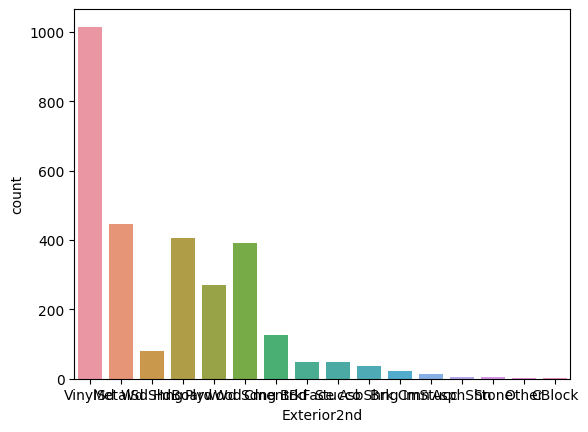

In [30]:
sns.countplot(x="Exterior2nd",data=data)